In [1]:
# These are the caclulation for benefist and reserves on two lifes
# Essentially we use the identical approach as for one person
# The main change is the need to update the recursion for reserves to two people
#  Structurally we now have everything for two people
#  Theory see below

import math
import numpy as np

filename = "EK95.txt"
EKMF95 = np.loadtxt(filename, skiprows=0)

#print(EKMF95[20,:])

def QxEK95(gender,x,t,param =[]):
    return(EKMF95[x,gender+1])

def Qx(gender,x,t,param =[]):
    # This is our default mortality
    if gender == 0:
        a =[2.34544649e+01,8.70547812e-02,7.50884047e-05,-1.67917935e-02]
    else:
        a =[2.66163571e+01,8.60317509e-02,2.56738012e-04,-1.91632675e-02]
    return(np.exp(a[0]+(a[1]+a[2]*x)*x+a[3]*t))

def QxNoReduction(gender,x,t,param =[]):
    # This is our default mortality
    t = 2015
    if gender == 0:
        a =[2.34544649e+01,8.70547812e-02,7.50884047e-05,-1.67917935e-02]
    else:
        a =[2.66163571e+01,8.60317509e-02,2.56738012e-04,-1.91632675e-02]
    return(np.exp(a[0]+(a[1]+a[2]*x)*x+a[3]*t))

def QxMedieval(gender,x,t,param =[]):
    a=-9.13275
    b= 8.09432e-2
    c= -1.1018e-5
    value=math.exp(a+(b+c*x)*x)
    alpha = 7.26502413
    beta = 0.01342065
    return(max(0,min(1,alpha*value+beta)))

def ConstantBenefit(x,param=[]):
    return(1.)

def ZeroBenefit(x,param=[]):
    return(0.)

def ExpBenefit(x,param=[]):
    x0 = param[0]
    alpha = param[1]
    return((1+alpha)**(x-x0))

def DeferredBenefit(x,param=[]):
    x0 = param[0]
    if x>= x0: return(1)
    return(0)

**Two Lives**

Given $q_x$ and $q_y$ and benefits

States are $(\star,\star)$, $(\dagger,\star)$, $(\star,\dagger)$, $(\dagger,\dagger)$

1) Mortality Benfits: $(\star,\star) \to (\dagger,\star)$ (3 types) and $(\star,\dagger) \to (\dagger,\dagger)$ (2 types): Benefits $B_{(\star,\star) \to (\dagger,\star)}$

2) Survival Benefits: at maturity the policy is in state  $(\star,\star)$, $(\dagger,\star)$, $(\star,\dagger)$ (3 types): Benefits $M_{(\star,\star)}$

3) Annuities: $(\star,\star)$, $(\dagger,\star)$, $(\star,\dagger)$ (3 types) Benefits $R_{(\star,\star)}$

We have three types of reserves

 $V_{(\star,\star)}$, $V_{(\dagger,\star)}$, $V_{(\star,\dagger)}$ (3 types)
 

We already now the recursion for states where one person is already death. Example $x$ passed away and we are in the state $ (\dagger,\star)$
 
\begin{eqnarray*}
V(y) & = & R_{(\dagger,\star)}(y) + q_y \, v \, B_{(\dagger,\star) \to (\dagger,\dagger)}(y) + (1- q_y )\, v \, V(y+1)
\end{eqnarray*}

For the state $(\star,\star)$ we have the following recursion

\begin{eqnarray*}
V_{(\star,\star)}(x,y) = && R_{(\star,\star)} (x,y)  \\
 &+& (1-q_x) \, (1-q_y) \, v \times \{V(x+1, y+1)\} \\
 &+& q_x \, (1-q_y) \, v \times \{B_{(\star,\star) \to (\dagger,\star)}(x,y) + V(y+1)\} \\
 &+& (1-q_x) \, q_y \, v \times \{B_{(\star,\star) \to (\star, \dagger)}(x,y) + V(x+1)\} \\
 &+& q_x \, q_y \, v \times \{B_{(\star,\star) \to (\dagger, \dagger)}(x,y)\} \\
\end{eqnarray*}

These are the insurer benefits, for mathematical reserves we need consider the premiums as negative annuities

In [2]:
import numpy as np
import matplotlib.pyplot as plt

class Benefit2:
    def __init__(self,Qx,i=0.02,omega=110,t0 = 2020):
        self.dIrate = i
        self.nOmega = omega
        self.psymB1 = ZeroBenefit # Death benefit for life x when y death
        self.psymB2 = ZeroBenefit # Death benefir for life y
        self.psymB12 = ZeroBenefit # Death Benefit for life x,y together joint status ends
        self.psymR1 = ZeroBenefit # Annuity x (y is death)
        self.psymR2 = ZeroBenefit # Annuity y (x is death) [Widow pension]
        self.psymR12 = ZeroBenefit # Joint Annuity
        self.psymM1 = ZeroBenefit # Maturity benefit (*t)
        self.psymM2 = ZeroBenefit # Maturity benefit (t*)
        self.psymM12 = ZeroBenefit # Joint Maturity Benefit ( nE_{x:y})
        self.psymQx = Qx
        self.dV = 1. /(1+self.dIrate)
        self.nT0 = t0
        
        
    def CalcPV(self,gender1,gender2,x,deltaxy, s,param=[],bTrace=False):
        n  = s-x
        PV1 =0 # for state (*t)
        PV2 =0 # for state (t*)
        PV12=0 # Both alive (**)
        for i in range(s-1,x-1,-1):
            t = self.nT0 + i - x
            iy = i + deltaxy
            qx = self.psymQx(gender1,i,t)
            qy = self.psymQx(gender2,iy,t)
            px = 1. - qx
            py = 1. - qy
            if bTrace:
                print("------")
                print("t,x,y",t,i,iy)
                print("qx,qy,px,py",qx,qy,px,py)
                print("Rex EoP PV1 PV2 PV12",PV1,PV2,PV12)
            # state (12) <--> both are alive (*,*)
            # state (1) <--> (*t)
            # state (2) <--> (t*)
            PV12 = self.psymR12(i,param=param) + px * py * self.dV * PV12
            PV12 += px * qy * self.dV * (self.psymB12(i,param=param) + PV1)
            PV12 += py * qx * self.dV * (self.psymB12(i,param=param) + PV2)
            PV12 += qx * qy * self.dV * (self.psymB12(i,param=param))
            PV1 = self.psymR1(i,param=param) + qx * self.dV * self.psymB1(i,param=param) + px * self.dV * PV1
            PV2 = self.psymR2(i,param=param) + qy * self.dV * self.psymB2(i,param=param) + py * self.dV * PV2
            if i==s-1:
                PV1 += px * self.dV * self.psymM1(s,param=param)
                PV2 += py * self.dV * self.psymM2(s,param=param)
                PV12 += px * py * self.dV * self.psymM12(s,param=param)

            if bTrace:
                print("Res BoP PV1 PV2 PV12",PV1,PV2,PV12)
                print("------")
            
        return(np.array([PV1,PV2,PV12]))
    

    
class DK2:
    def __init__(self,Qx, i=0.02,omega=110,t0 = 2020):
        self.dIrate = i
        self.nOmega = omega
        self.psymB1 = ZeroBenefit
        self.psymB2 = ZeroBenefit
        self.psymB12 = ZeroBenefit
        self.psymR1 = ZeroBenefit
        self.psymR2 = ZeroBenefit
        self.psymR12 = ZeroBenefit
        self.psymM1 = ZeroBenefit
        self.psymM2 = ZeroBenefit
        self.psymM12 = ZeroBenefit
        self.psymP1 = ZeroBenefit
        self.psymP2 = ZeroBenefit
        self.psymP12 = ZeroBenefit
        self.dPrem = None
        self.psymQx = Qx
        self.dV = 1. /(1+self.dIrate)
        self.nT0 = t0
        self.psymLeist = Benefit2(Qx,i=i,omega=omega,t0 = t0)
        self.psymPraem = Benefit2(Qx,i=i,omega=omega,t0 = t0)
        self.nSL = None
        self.nSP = None
        self.nDeltaXy = None
        self.nGender1 = None
        self.nGender2 = None
    
    def CalcPremium(self,gender1, gender2, x, y, sL, sP,param=[]):
        self.nSL = sL
        self.nSP = sP
        self.nDeltaXy = y - x
        self.nGender1 = gender1
        self.nGender2 = gender2
        self.psymLeist.psymB1 = self.psymB1
        self.psymLeist.psymB2 = self.psymB2
        self.psymLeist.psymB12 = self.psymB12
        self.psymLeist.psymR1 = self.psymR1
        self.psymLeist.psymR2 = self.psymR2
        self.psymLeist.psymR12 = self.psymR12
        self.psymLeist.psymM1 = self.psymM1
        self.psymLeist.psymM2 = self.psymM2
        self.psymLeist.psymM12 = self.psymM12
        self.psymPraem.psymR1 = self.psymP1
        self.psymPraem.psymR2 = self.psymP2
        self.psymPraem.psymR12 = self.psymP12
        # gender1,gender2,x,deltaxy, s,param=[]
        self.dPrem = self.psymLeist.CalcPV(self.nGender1,self.nGender2,x,self.nDeltaXy,self.nSL,param=param)[2]/self.psymPraem.CalcPV(self.nGender1,self.nGender2,x,self.nDeltaXy,self.nSP,param=param)[2]
        print(self.psymLeist.CalcPV(self.nGender1,self.nGender2,x,self.nDeltaXy,self.nSL,param=param),self.psymPraem.CalcPV(self.nGender1,self.nGender2,x,self.nDeltaXy,self.nSP,param=param))
        print("Premium =",self.dPrem)
    
    def CalcPV(self,x,param=[]):
        PVL = self.psymLeist.CalcPV(self.nGender1,self.nGender2,x,self.nDeltaXy,self.nSL,param=param)
        PVP = self.psymPraem.CalcPV(self.nGender1,self.nGender2,x,self.nDeltaXy,self.nSP,param=param) * self.dPrem
        PV = PVL - PVP
        return([PVL, PVP, PV])
    


***Widdow Pension***
We consider a widdows pension (Life 2) and assume that x=30, y = 27 and $\omega = 110$.
We would like to calculate the premium assuming that the premium is due until $s_x=65$ in case both are alive, ie ony P12 is nontrivial. We want to have graphs for the mathematical reserve in case both alive PV12 and in case the man has died.

$\ddot{a}_{x|y}$

Test Witenrente
[ 0.         33.75920913  4.48533172] [ 0.         0.        24.1491775]
Premium = 0.18573434746302214


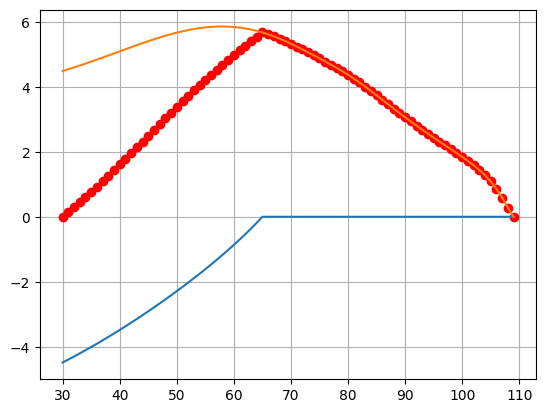

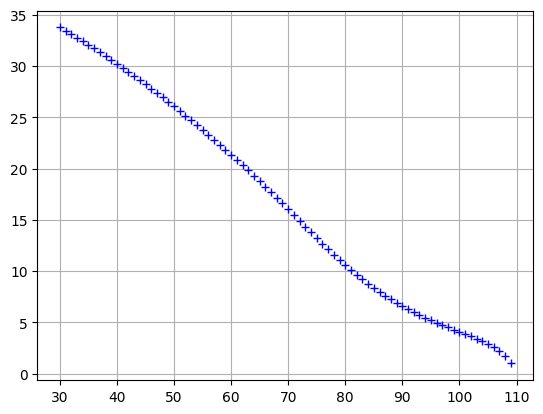

In [3]:
print("Test Witenrente")

w = DK2(QxEK95)
w.psymR2 = ConstantBenefit
w.psymP12 = ConstantBenefit
gender1 = 0
gender2 = 1
x = 30
y = 27
sL = 110
sP = 65
w.CalcPremium(gender1, gender2, x, y, sL, sP,param=[])

#w.psymLeist.CalcPV(gender1,gender2,x,y-x, sL,param=[],bTrace=True)

xPlot =[]
y12T=[]
y12P=[]
y12L=[]
y2=[]

for i in range(x,110):
    [PVL, PVP, PV] = w.CalcPV(i,param=[])
    xPlot.append(i)
    y12T.append(PV[2])
    y12L.append(PVL[2])
    y12P.append(-PVP[2])
    y2.append(PV[1])

plt.figure(1)
plt.plot(xPlot,y12T,"ro",xPlot,y12P,xPlot,y12L)
plt.grid(True)

plt.figure(2)
plt.plot(xPlot,y2,"b+")
plt.grid(True)

Now the same for a symetrical widdow pension $\ddot{a}_{xy}^1 =
\ddot{a}_{x|y} + \ddot{a}_{y|x}$

Test Witenrente symetrical
[30.918349   33.75920913  6.12980332] [ 0.         0.        24.1491775]
Premium = 0.2538307284649422


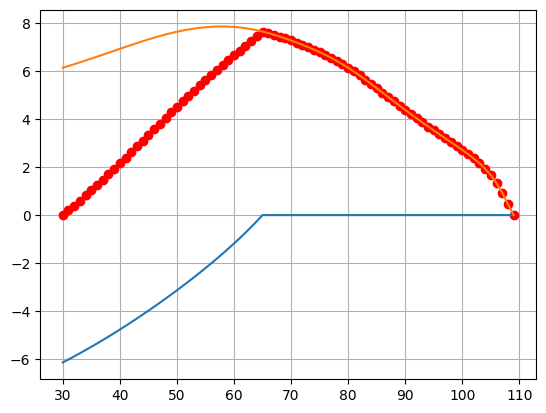

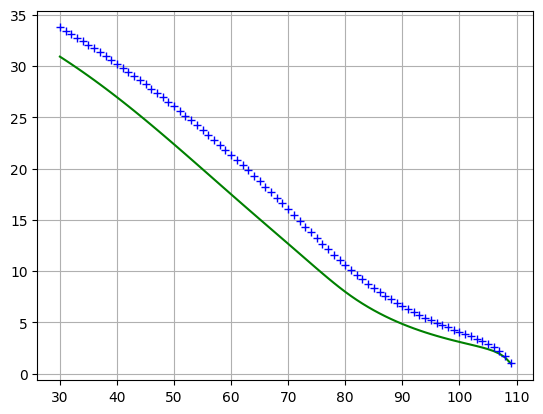

In [4]:
print("Test Witenrente symetrical")

ws = DK2(QxEK95)
ws.psymR1 = ConstantBenefit
ws.psymR2 = ConstantBenefit
ws.psymP12 = ConstantBenefit
gender1 = 0
gender2 = 1
x = 30
y = 27
sL = 110
sP = 65
ws.CalcPremium(gender1, gender2, x, y, sL, sP,param=[])

xPlot =[]
y12T=[]
y12P=[]
y12L=[]
y1=[]
y2=[]


for i in range(x,110):
    [PVL, PVP, PV] = ws.CalcPV(i,param=[])
    xPlot.append(i)
    y12T.append(PV[2])
    y12L.append(PVL[2])
    y12P.append(-PVP[2])
    y1.append(PV[0])
    y2.append(PV[1])

plt.figure(1)
plt.plot(xPlot,y12T,"ro",xPlot,y12P,xPlot,y12L)
plt.grid(True)

plt.figure(2)
plt.plot(xPlot,y1,"g-",xPlot,y2,"b+")
plt.grid(True)

***Mixed Endowment on joint life status***
We consider a $A_{xy:n}$ and assume that x=30, y = 27 and s = 65.
We would like to calculate the p
remium assuming that the premium is due until $s=65$.
In this case we have B12=M12=constant and P12=constant, rest equal 0. 



Joint Life Endowment
[0.         0.         0.50984697] [ 0.          0.         24.99780441]
Premium = 0.020395670120905162


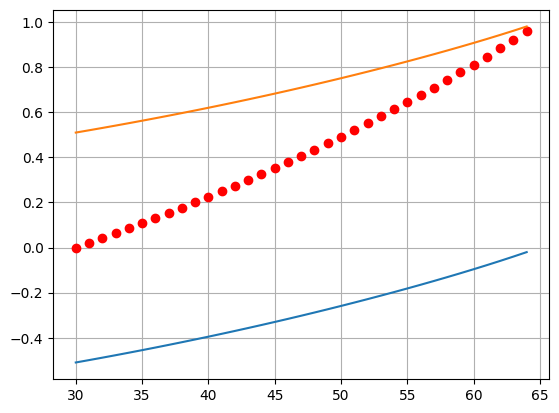

In [5]:
print("Joint Life Endowment")

axy = DK2(Qx)
axy.psymM12 = ConstantBenefit
axy.psymB12 = ConstantBenefit
axy.psymP12 = ConstantBenefit
gender1 = 0
gender2 = 1
x = 30
y = 27
sL = 65
sP = 65
axy.CalcPremium(gender1, gender2, x, y, sL, sP,param=[])

xPlot =[]
y12T=[]
y12P=[]
y12L=[]

for i in range(x,sL):
    [PVL, PVP, PV] = axy.CalcPV(i,param=[])
    xPlot.append(i)
    y12T.append(PV[2])
    y12L.append(PVL[2])
    y12P.append(-PVP[2])
 
plt.figure(3)
plt.plot(xPlot,y12T,"ro",xPlot,y12P,xPlot,y12L)
plt.grid(True)

Now the same for the last survivor status $A_{\bar{xy}:n}$:


Joint Life Endowment
[0.50827915 0.50165282 0.49673996] [25.07776312 25.41570593 25.49566465]
Premium = 0.019483310679690547


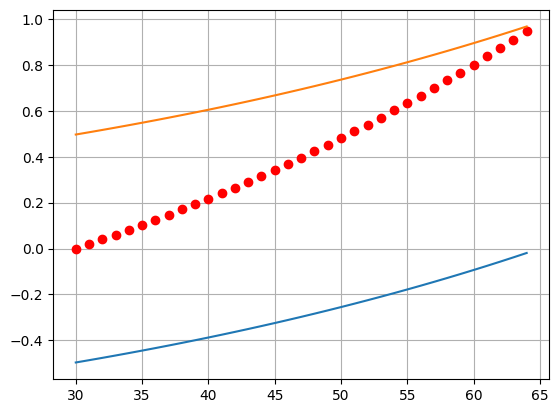

In [6]:
print("Joint Life Endowment")

axybar = DK2(Qx)
axybar.psymM12 = ConstantBenefit
axybar.psymM2 = ConstantBenefit
axybar.psymM1 = ConstantBenefit
axybar.psymB12 = ZeroBenefit
axybar.psymB1 = ConstantBenefit
axybar.psymB2 = ConstantBenefit
axybar.psymP12 = ConstantBenefit
axybar.psymP1 = ConstantBenefit
axybar.psymP2 = ConstantBenefit
gender1 = 0
gender2 = 1
x = 30
y = 27
sL = 65
sP = 65
axybar.CalcPremium(gender1, gender2, x, y, sL, sP,param=[])

xPlot =[]
y12T=[]
y12P=[]
y12L=[]

for i in range(x,sL):
    [PVL, PVP, PV] = axybar.CalcPV(i,param=[])
    xPlot.append(i)
    y12T.append(PV[2])
    y12L.append(PVL[2])
    y12P.append(-PVP[2])
 
plt.figure(4)
plt.plot(xPlot,y12T,"ro",xPlot,y12P,xPlot,y12L)
plt.grid(True)

Finally we look a a term insurance on the joint life until s=80 with premium payment until 65. $A_{xy:n}^1$

Term Insurance
[0.         0.         0.12996108] [ 0.          0.         24.99780441]
Premium = 0.005198899929322986


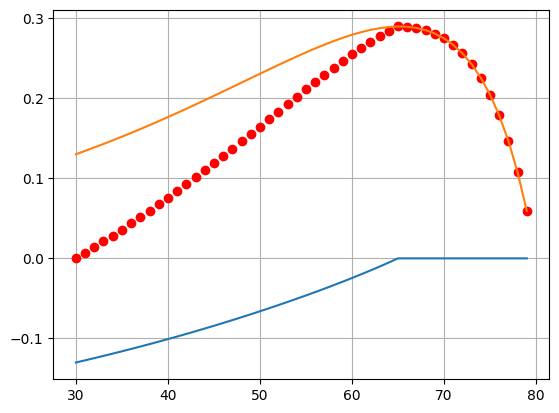

In [7]:
print("Term Insurance")

axy1 = DK2(Qx)
axy1.psymB12 = ConstantBenefit
axy1.psymP12 = ConstantBenefit
gender1 = 0
gender2 = 1
x = 30
y = 27
sL = 80
sP = 65
axy1.CalcPremium(gender1, gender2, x, y, sL, sP,param=[])

xPlot =[]
y12T=[]
y12P=[]
y12L=[]

for i in range(x,sL):
    [PVL, PVP, PV] = axy1.CalcPV(i,param=[])
    xPlot.append(i)
    y12T.append(PV[2])
    y12L.append(PVL[2])
    y12P.append(-PVP[2])
 
plt.figure(4)
plt.plot(xPlot,y12T,"ro",xPlot,y12P,xPlot,y12L)
plt.grid(True)